# Overview
The notebook shows how the ```lime_image``` tools can be applied to a smaller dataset like mnist. The dataset is very low resolution and allows quite a bit of rapid-iteration.

In [40]:
import numpy as np #Math Library
import matplotlib.pyplot as plt #Allows you to display plots
from skimage.color import gray2rgb, rgb2gray, label2rgb #gray2rgb creats an RGB representation of a gray-level image, label2rgb returns an rgb image where color coded labels are painted over the image, rest are self explanatory
import pandas as pd #Manipulates data

In [41]:
from sklearn.datasets import fetch_openml #loads datasets
mnist = fetch_openml('mnist_784', parser='auto') #mnist_784 is the name of the dataset and it is assigned to variable mnist
# make each image color so lime_image works correctly
data = mnist.data.to_numpy() #converts the pandas dataframe to numpy
data = np.reshape(data, (-1, 28, 28)) #reshapes the numpy ndarray
X_vec = np.stack([gray2rgb(iimg) for iimg in data],0).astype(np.uint8) #converts every pixel in the image to rgb using list comprehension
y_vec = mnist.target.astype(np.uint8)

Text(0.5, 1.0, 'Digit: 5')

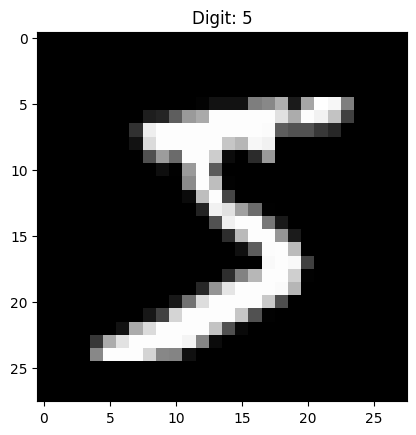

In [42]:
%matplotlib inline 
#used for notebook to display plot below instead of opening up a new window
fig, ax1 = plt.subplots(1,1) #Creates a plot
ax1.imshow(X_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0])) # Sets the title for first image

# Setup a Pipeline
Here we make a pipeline for processing the images where basically we flatten the image back to 1d vectors and then use a RandomForest Classifier

In [43]:
from sklearn.pipeline import Pipeline #Pipeline assembles several steps in order
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list]) #Makes all the images gray
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list]) #Flattens the images

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    # ('Normalize', Normalizer()),
    # ('PCA', PCA(16)),
    ('RF', RandomForestClassifier())
                              ])

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.55) #Splits the data 

In [45]:
simple_rf_pipeline.fit(X_train, y_train) #fits the model

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x1508b7040>),
                ('Flatten Image', <__main__.PipeStep object at 0x157d813d0>),
                ('RF', RandomForestClassifier())])

In [46]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime #imports lime and below if something goes wrong
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [48]:
%%time
explanation = explainer.explain_instance(X_test[0], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 5.33 s, sys: 141 ms, total: 5.47 s
Wall time: 4.82 s


Text(0.5, 1.0, 'Positive/Negative Regions for 5')

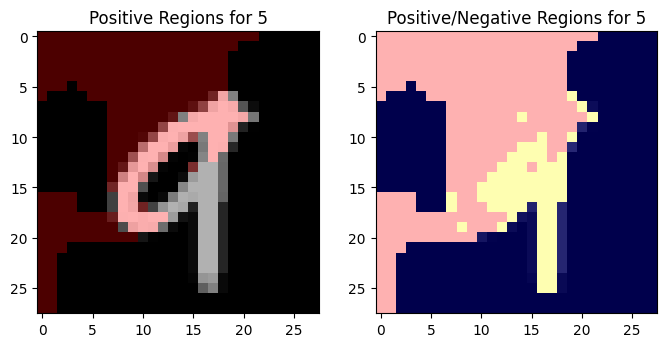

In [54]:

temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01) #initilization function
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4)) #
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[0]))
#Positive/Negative Regions
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[0]))

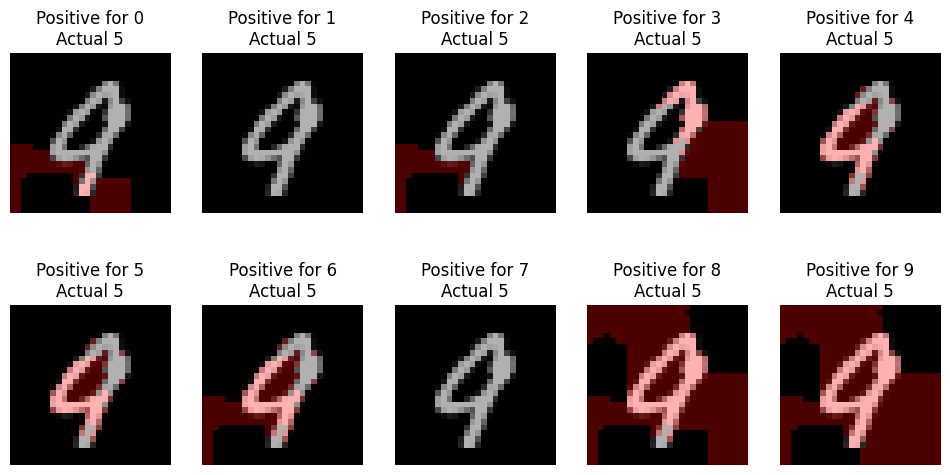

In [50]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,X_test[0], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[0]))
    c_ax.axis('off')

# Gaining Insight
Can we find an explanation for a classification the algorithm got wrong

In [51]:
pipe_pred_test = simple_rf_pipeline.predict(X_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Using #5767 where the label was 0 and the pipeline predicted 4


In [52]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx], 
                                         classifier_fn = simple_rf_pipeline.predict_proba, 
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 6.22 s, sys: 242 ms, total: 6.46 s
Wall time: 6.8 s


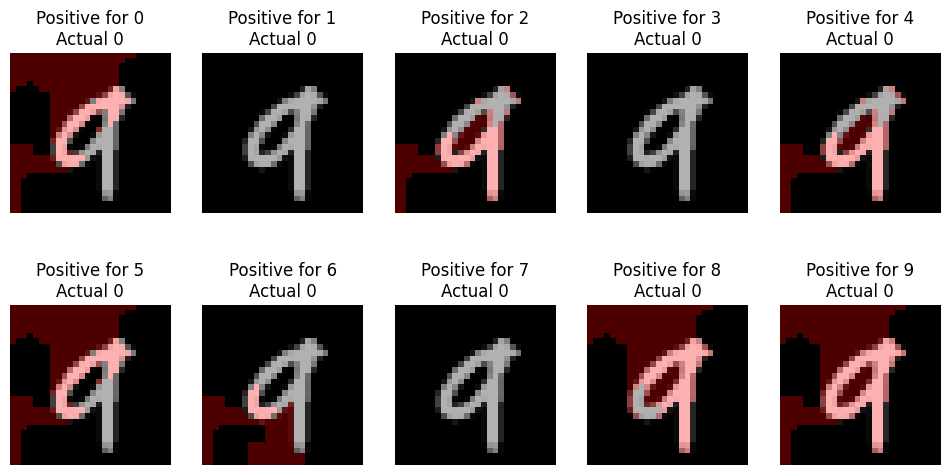

In [53]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[wrong_idx]))
    c_ax.axis('off')